In [34]:
# What is a dynamic pricing strategy? Well, in the simplest terms, dynamic pricing means adjusting prices based on factors like supply, demand, competition, or other market conditions. 
# It's about staying flexible with pricing based on what's happening. 

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Loading our dataset
# Load the dataset
data = pd.read_csv("C:/Users/Josep/OneDrive/Desktop/dynamic_pricing.csv")
print(data.head())

print(data.describe())

   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76  

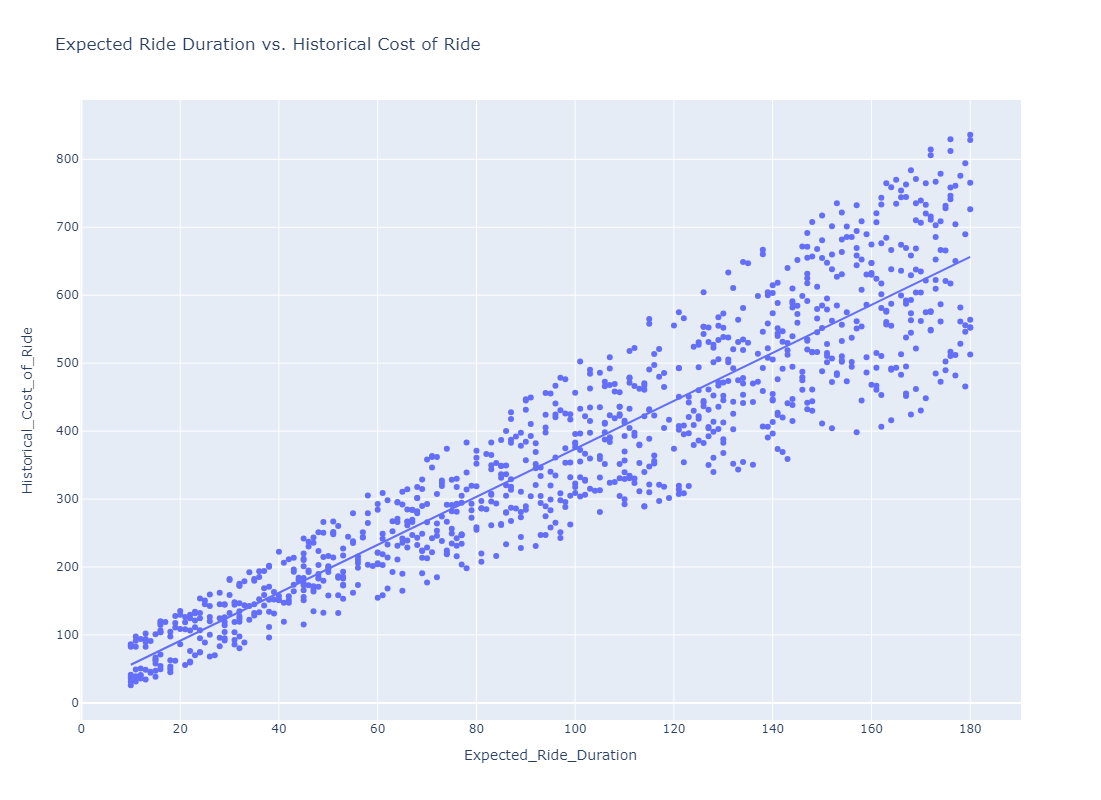

In [35]:
import plotly.express as px

# Depicting the relationship between expected ride duration and the historical cost of the ride:
fig = px.scatter(data, x='Expected_Ride_Duration', 
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride', 
                 trendline='ols')

# Updating layout to increase plot height
fig.update_layout(
    height=800  
)

fig.show()

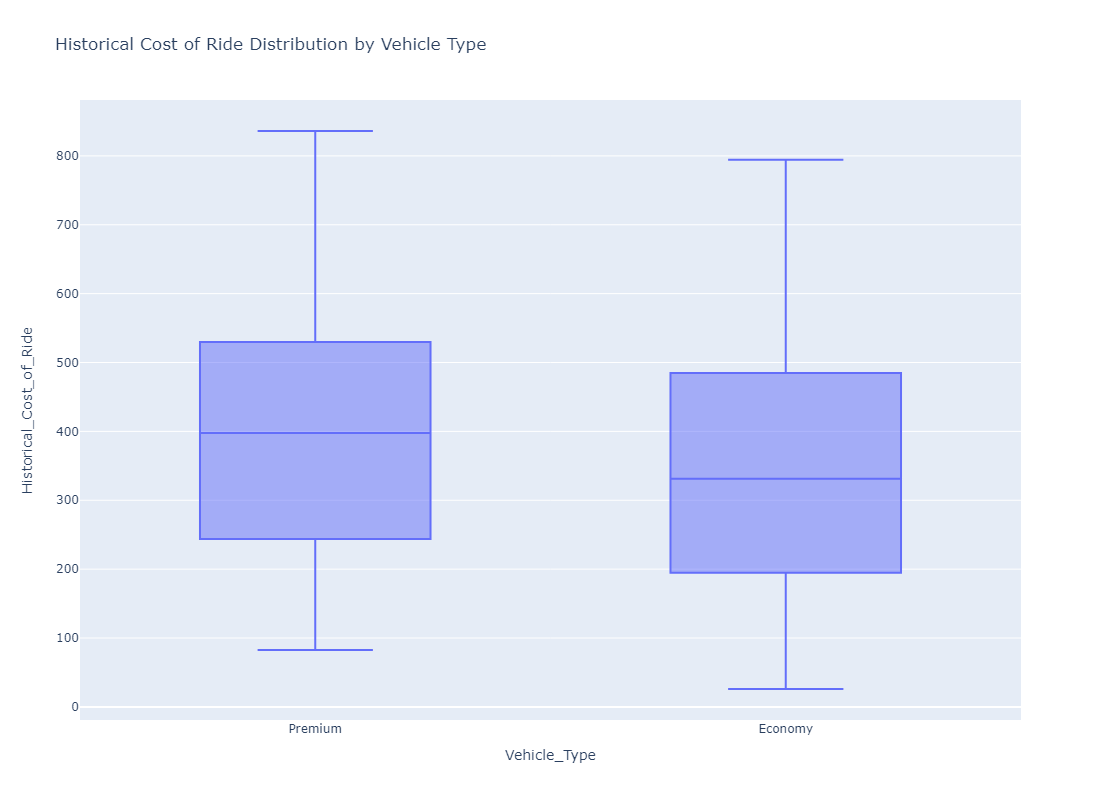

In [36]:
import plotly.express as px

# Depicting the distribution of the historical cost of rides based on the vehicle type:
fig = px.box(data, x='Vehicle_Type', 
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution by Vehicle Type')

# Updating layout to increase plot height
fig.update_layout(
    height=800 
)

fig.show()


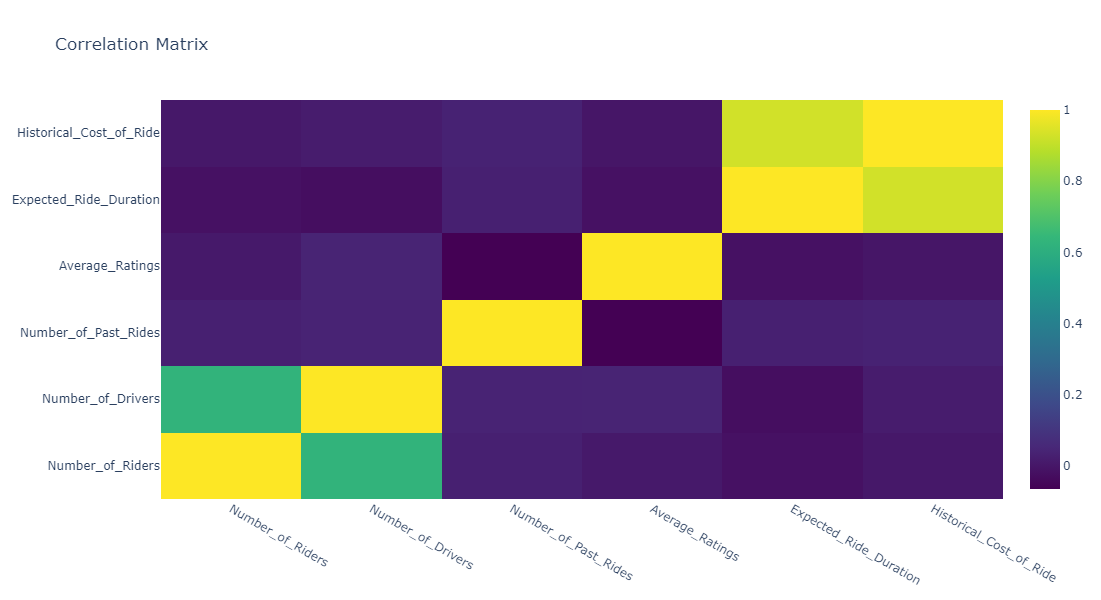

In [37]:
import pandas as pd
import plotly.graph_objects as go

# Assuming 'data' is your DataFrame containing both numeric and non-numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns

# Computing correlation matrix for numeric columns
corr_matrix = numeric_data.corr()

# Creating heatmap plot using Plotly
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,  
    x=corr_matrix.columns,  
    y=corr_matrix.columns,  
    colorscale='Viridis'    
))

# Updating layout and display the plot
fig.update_layout(
    title='Correlation Matrix',  
    height=600                   
)
fig.show()  


In [38]:
 # implementing this dynamic pricing strategy using Python:

import numpy as np

# Calculating demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculating supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Defining price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  
demand_threshold_low = 0.8  
supply_threshold_high = 0.8  
supply_threshold_low = 1.2  


# Calculating adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

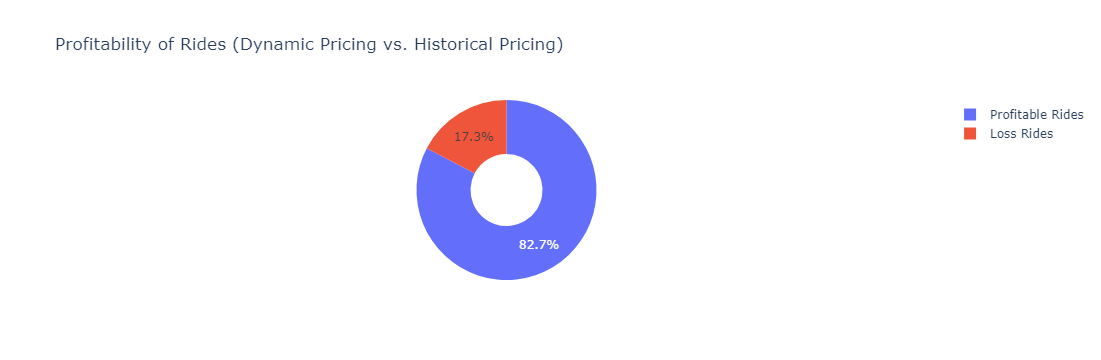

In [39]:
# Calculating the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identifying loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]


import plotly.graph_objects as go

# Calculating the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Creating a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

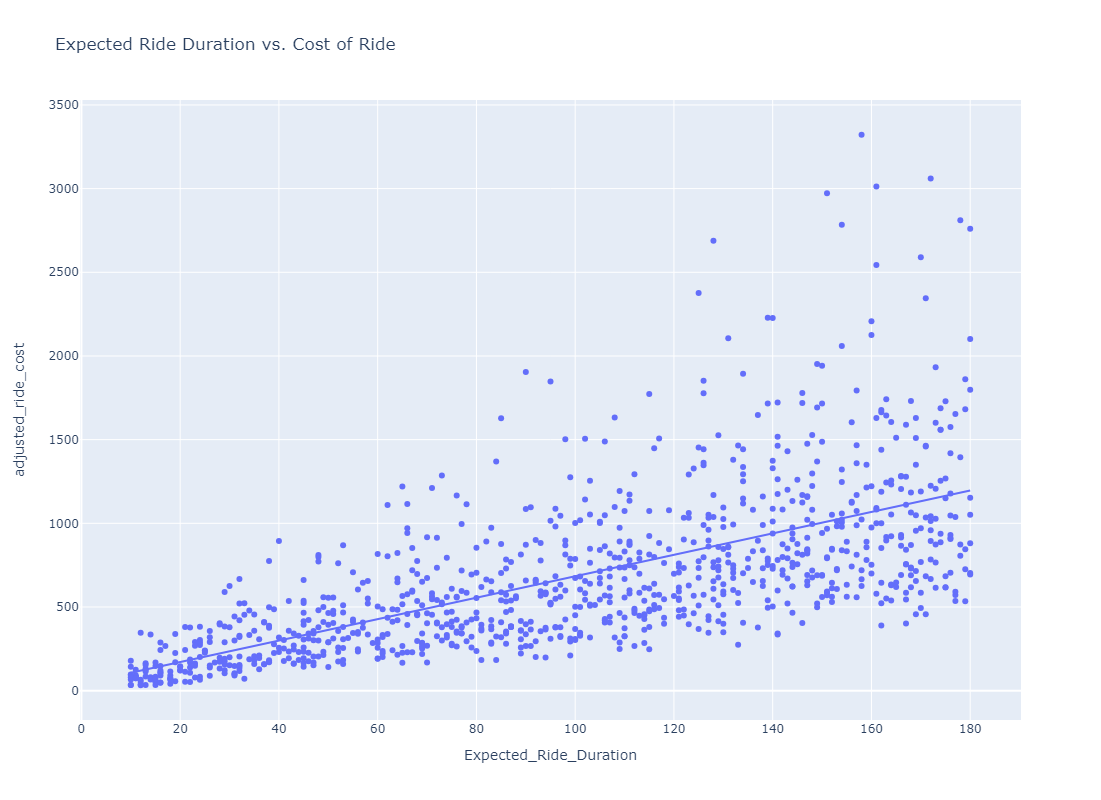

In [40]:
import plotly.express as px

# Depicting the relationship between the expected ride duration and the cost of the ride based on the dynamic pricing strategy:
fig = px.scatter(data, 
                 x='Expected_Ride_Duration', 
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Cost of Ride', 
                 trendline='ols')

# Update layout to increase plot height
fig.update_layout(
    height=800  
)

fig.show()


In [41]:
# Training a Predictive Model

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(data):
    # Identifying numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    # Handling missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    # Detecting and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    # Handling missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

Predicted price: [95.46092711]


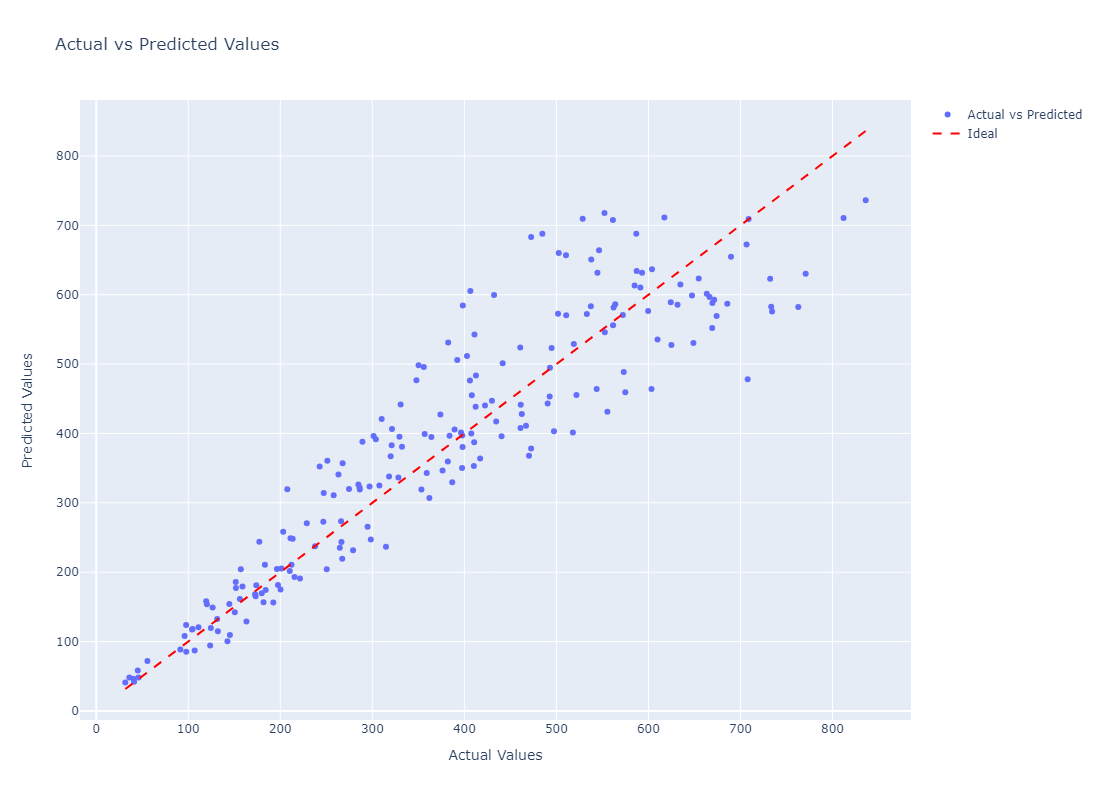

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Converting Vehicle_Type to numerical feature
data["Vehicle_Type"] = data["Vehicle_Type"].map({"Premium": 1, "Economy": 0})

# Selecting features and target variable
x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(data["Historical_Cost_of_Ride"])  # Assuming this is the target variable

# Spliting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Training a random forest regression model
model = RandomForestRegressor()
model.fit(x_train, y_train)

# Defining function to convert vehicle type to numeric
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {"Premium": 1, "Economy": 0}
    return vehicle_type_mapping.get(vehicle_type)

# Defining function to predict price based on input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, expected_ride_duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, expected_ride_duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
expected_ride_duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, expected_ride_duration)
print("Predicted price:", predicted_price)

# Comparing actual vs predicted results using a scatter plot
y_pred = model.predict(x_test)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
    height=800  
)

fig.show()
